In [18]:
import pandas as pd
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.callbacks import Callback
from imblearn.over_sampling import SMOTE
import seaborn as sns

In [3]:
# Load the dataset
data = pd.read_csv(Path('Fraudulent_E-Commerce_Transaction_Data.csv'))

# Review the DataFrame
print(data.nunique())
data.head()


Transaction ID        1472952
Customer ID           1472952
Transaction Amount     109257
Transaction Date      1346684
Payment Method              4
Product Category            5
Quantity                    5
Customer Age               97
Customer Location       99135
Device Used                 3
IP Address            1472651
Shipping Address      1472948
Billing Address       1472949
Is Fraudulent               2
Account Age Days          365
Transaction Hour           24
dtype: int64


,Transaction ID,Customer ID,Transaction Amount,Transaction Date,Payment Method,Product Category,Quantity,Customer Age,Customer Location,Device Used,IP Address,Shipping Address,Billing Address,Is Fraudulent,Account Age Days,Transaction Hour
0,15d2e414-8735-46fc-9e02-80b472b2580f,d1b87f62-51b2-493b-ad6a-77e0fe13e785,58.09,2024-02-20 05:58:41,bank transfer,electronics,1,17,Amandaborough,tablet,212.195.49.198,Unit 8934 Box 0058\nDPO AA 05437,Unit 8934 Box 0058\nDPO AA 05437,0,30,5
1,0bfee1a0-6d5e-40da-a446-d04e73b1b177,37de64d5-e901-4a56-9ea0-af0c24c069cf,389.96,2024-02-25 08:09:45,debit card,electronics,2,40,East Timothy,desktop,208.106.249.121,"634 May Keys\nPort Cherylview, NV 75063","634 May Keys\nPort Cherylview, NV 75063",0,72,8
2,e588eef4-b754-468e-9d90-d0e0abfc1af0,1bac88d6-4b22-409a-a06b-425119c57225,134.19,2024-03-18 03:42:55,PayPal,home & garden,2,22,Davismouth,tablet,76.63.88.212,"16282 Dana Falls Suite 790\nRothhaven, IL 15564","16282 Dana Falls Suite 790\nRothhaven, IL 15564",0,63,3
3,4de46e52-60c3-49d9-be39-636681009789,2357c76e-9253-4ceb-b44e-ef4b71cb7d4d,226.17,2024-03-16 20:41:31,bank transfer,clothing,5,31,Lynnberg,desktop,207.208.171.73,"828 Strong Loaf Apt. 646\nNew Joshua, UT 84798","828 Strong Loaf Apt. 646\nNew Joshua, UT 84798",0,124,20
4,074a76de-fe2d-443e-a00c-f044cdb68e21,45071bc5-9588-43ea-8093-023caec8ea1c,121.53,2024-01-15 05:08:17,bank transfer,clothing,2,51,South Nicole,tablet,190.172.14.169,"29799 Jason Hills Apt. 439\nWest Richardtown, ...","29799 Jason Hills Apt. 439\nWest Richardtown, ...",0,158,5


In [4]:
# Display dataset structure
print(data.info())

# View the first few rows
print(data.head())

# Check for missing values
print(data.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1472952 entries, 0 to 1472951
Data columns (total 16 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   Transaction ID      1472952 non-null  object 
 1   Customer ID         1472952 non-null  object 
 2   Transaction Amount  1472952 non-null  float64
 3   Transaction Date    1472952 non-null  object 
 4   Payment Method      1472952 non-null  object 
 5   Product Category    1472952 non-null  object 
 6   Quantity            1472952 non-null  int64  
 7   Customer Age        1472952 non-null  int64  
 8   Customer Location   1472952 non-null  object 
 9   Device Used         1472952 non-null  object 
 10  IP Address          1472952 non-null  object 
 11  Shipping Address    1472952 non-null  object 
 12  Billing Address     1472952 non-null  object 
 13  Is Fraudulent       1472952 non-null  int64  
 14  Account Age Days    1472952 non-null  int64  
 15  Transaction Hou

In [5]:
# Drop irrelevant columns
data_cleaned = data.drop(columns=['Transaction ID', 'Customer ID', 'IP Address', 'Shipping Address', 'Billing Address', 'Customer Location'])
data_cleaned


# Convert 'Transaction Date' to datetime and extract features
data_cleaned['Transaction Date'] = pd.to_datetime(data_cleaned['Transaction Date'])
data_cleaned['Year'] = data_cleaned['Transaction Date'].dt.year
data_cleaned['Month'] = data_cleaned['Transaction Date'].dt.month
data_cleaned['Day'] = data_cleaned['Transaction Date'].dt.day
data_cleaned['Hour'] = data_cleaned['Transaction Date'].dt.hour
data_cleaned = data_cleaned.drop(columns=['Transaction Date'])


data_cleaned = pd.get_dummies(data_cleaned, columns=['Payment Method', 'Product Category', 'Device Used'], drop_first=True)
data_cleaned



,Transaction Amount,Quantity,Customer Age,Is Fraudulent,Account Age Days,Transaction Hour,Year,Month,Day,Hour,Payment Method_bank transfer,Payment Method_credit card,Payment Method_debit card,Product Category_electronics,Product Category_health & beauty,Product Category_home & garden,Product Category_toys & games,Device Used_mobile,Device Used_tablet
0,58.09,1,17,0,30,5,2024,2,20,5,True,False,False,True,False,False,False,False,True
1,389.96,2,40,0,72,8,2024,2,25,8,False,False,True,True,False,False,False,False,False
2,134.19,2,22,0,63,3,2024,3,18,3,False,False,False,False,False,True,False,False,True
3,226.17,5,31,0,124,20,2024,3,16,20,True,False,False,False,False,False,False,False,False
4,121.53,2,51,0,158,5,2024,1,15,5,True,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1472947,208.48,2,29,0,149,23,2024,1,12,23,False,False,False,False,True,False,False,False,False
1472948,231.57,2,32,0,132,4,2024,3,27,4,False,True,False,False,False,False,False,False,True
1472949,101.80,4,36,0,98,23,2024,1,31,23,True,False,False,True,False,False,False,True,False
1472950,61.80,5,34,0,191,16,2024,1,12,16,True,False,False,True,False,False,False,False,False


In [6]:
# Define features and target
X = data_cleaned.drop(columns=['Is Fraudulent'])
y = data_cleaned['Is Fraudulent']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

Features shape: (1472952, 18)
Target shape: (1472952,)


In [7]:
X

,Transaction Amount,Quantity,Customer Age,Account Age Days,Transaction Hour,Year,Month,Day,Hour,Payment Method_bank transfer,Payment Method_credit card,Payment Method_debit card,Product Category_electronics,Product Category_health & beauty,Product Category_home & garden,Product Category_toys & games,Device Used_mobile,Device Used_tablet
0,58.09,1,17,30,5,2024,2,20,5,True,False,False,True,False,False,False,False,True
1,389.96,2,40,72,8,2024,2,25,8,False,False,True,True,False,False,False,False,False
2,134.19,2,22,63,3,2024,3,18,3,False,False,False,False,False,True,False,False,True
3,226.17,5,31,124,20,2024,3,16,20,True,False,False,False,False,False,False,False,False
4,121.53,2,51,158,5,2024,1,15,5,True,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1472947,208.48,2,29,149,23,2024,1,12,23,False,False,False,False,True,False,False,False,False
1472948,231.57,2,32,132,4,2024,3,27,4,False,True,False,False,False,False,False,False,True
1472949,101.80,4,36,98,23,2024,1,31,23,True,False,False,True,False,False,False,True,False
1472950,61.80,5,34,191,16,2024,1,12,16,True,False,False,True,False,False,False,False,False


In [8]:
#Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)
X_train, X_test, y_train, y_test

(         Transaction Amount  Quantity  Customer Age  Account Age Days  \
 880819              1335.11         5            23                35   
 940422                92.90         2            24               204   
 361927               326.67         5            31               228   
 296530                11.00         3            45                65   
 609386                95.01         5            36               320   
 ...                     ...       ...           ...               ...   
 858137               161.47         2            36               222   
 1312744               17.23         1            51               108   
 252556                47.41         2            32               247   
 809571                35.72         1            49                38   
 308214               501.46         3            31                92   
 
          Transaction Hour  Year  Month  Day  Hour  \
 880819                  3  2024      2    2     3   
 9

In [9]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled: X
y_resampled: y
X_resampled, y_resampled = smote.fit_resample(X, y)

In [11]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [12]:
# intitialize and train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [13]:
# Make predictions
y_pred = model.predict(X_test)

In [14]:
# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97    279314
           1       0.98      0.96      0.97    280332

    accuracy                           0.97    559646
   macro avg       0.97      0.97      0.97    559646
weighted avg       0.97      0.97      0.97    559646



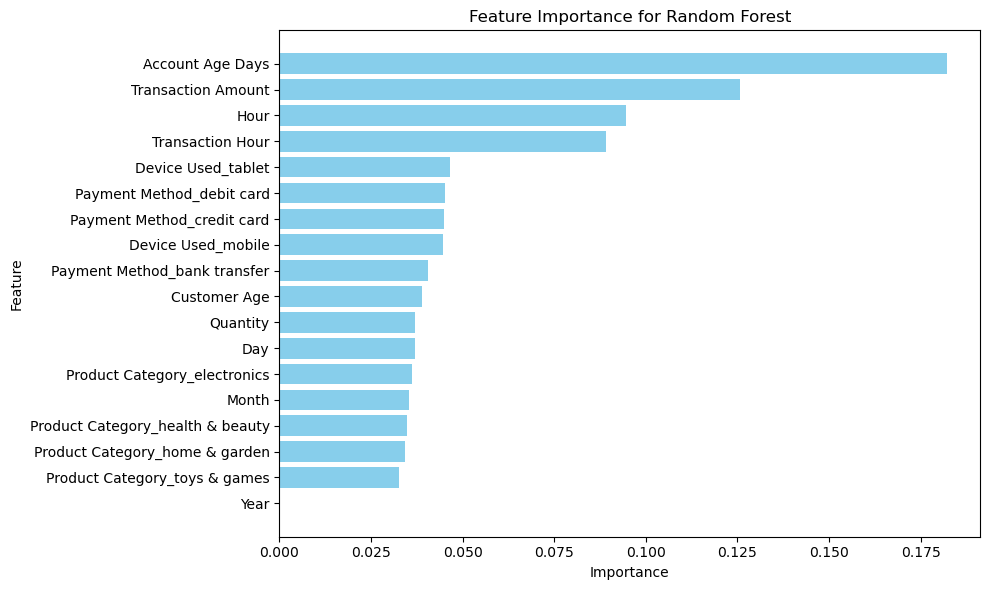

In [16]:
# Feature Importance Plot
feature_names = X.columns 
feature_importances = model.feature_importances_

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

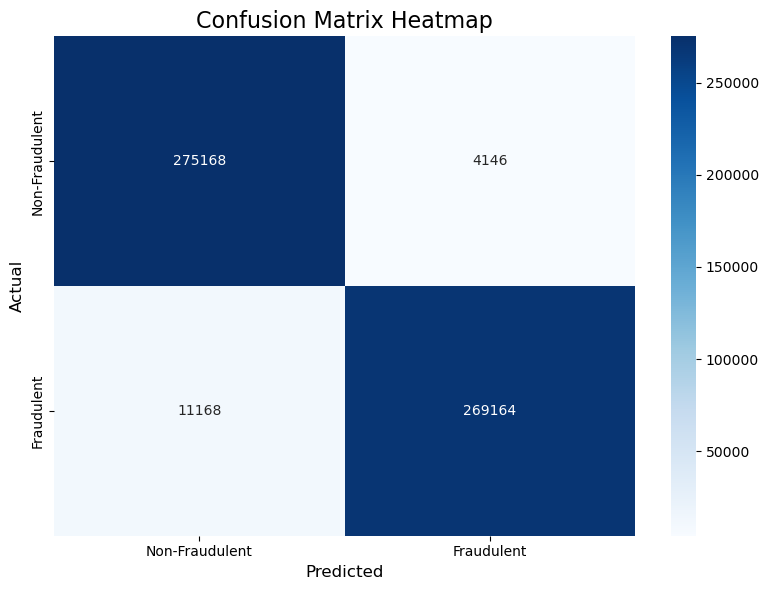

In [19]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = ['Non-Fraudulent', 'Fraudulent']

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix Heatmap", fontsize=16)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.tight_layout()
plt.show()